In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ase.io as aio
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy
import numba
from scipy.stats import moment
import pandas as pd
from scipy.spatial import cKDTree
import atom_stat
import atomistics as amks
import scipy.ndimage.morphology as morph
import numpy.fft as mf

In [3]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [12.0, 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [4]:
def epanechnikov(u, h):
    p = 0.75*(5**(-0.5))*(1 - (u**2)/(5*h**2))/h
    p[p<0] = 0
    return p


def mk_kernel(width, x):
    steps = x[1:] - x[:-1]
    width = width/np.sqrt(5)

    if not np.all(np.isclose(steps[0], steps)):
        raise ValueError('Bins need to be same width!')
        return None

    k_half = int((np.sqrt(5)*width)//steps[0] + 1)
    u = np.linspace(-k_half*steps[0],k_half*steps[0],k_half*2+1)

    kernel = epanechnikov(u=u, h=width)
    shift_to_mid = -len(kernel)//2 + 1
    kernel_arr = np.zeros(len(x))
    kernel_arr[:len(kernel)] = kernel
    kernel_arr = np.roll(kernel_arr, shift_to_mid)
    return kernel_arr


def conv_kernel(kern_arr, p):
    h1 = mf.fftn(kern_arr)
    h2 = mf.fftn(p)
    density = mf.ifftn(h1.conj() * h2).real
    return density

In [5]:
r_p = 20
bins = np.linspace(0, r_p + 2, 201)
bin_centers = bins[:-1] + bins[1:] - bins[:-1]
vols = 4 / 3 * np.pi * (bins[1:]**3 - bins[:-1]**3)

In [6]:
lst_all = np.zeros((6, 198))

In [8]:
%%time
for run in range(1,6):
    print(run)
    fname = "data_new/dump.Quench_Damaged.10000_Run-%d" % run
    atom = aio.read("coords/data_%d_new.xyz" % run)
    coords0 = atom.get_positions()
    print(coords0.shape)
    df = pd.read_table(fname, 
                       delimiter=" ",
                       skiprows=9,
                       header=None)
    coords = np.asarray(df.iloc[:,2:5])
    print(coords.shape)

    tree = cKDTree(coords)
    pdf = np.zeros(200)
    for coord in coords0:
        indexes = tree.query_ball_point(coord, r_p)
        distances = np.sqrt(np.sum((coords[indexes] - coord)**2, axis=1))
        pdf += np.histogram(distances, bins)[0]
    pdf = pdf / (coords0.shape[0])
    ix = 2
    lst = pdf[ix:] / vols[ix:]
    bin_centers1 = bins[ix:-1] + (bins[ix+1:] - bins[ix:-1])/2
    sing_kernel = mk_kernel(width=1.0, x=bin_centers1)
    lst = conv_kernel(sing_kernel, lst)
    lst_all[run, :] = lst

1
(10606, 3)
(6229504, 3)
2
(8995, 3)
(6229504, 3)
3
(8380, 3)
(6229504, 3)
4
(11505, 3)
(6229504, 3)
5
(11351, 3)
(6229504, 3)
CPU times: user 2min 3s, sys: 4.02 s, total: 2min 7s
Wall time: 2min 5s


In [9]:
ind = np.random.randint(1, 10000, 100)

In [10]:
run = 0
fname = fname = "data_old/dump.Si_Perfect_Quenched"
df = pd.read_table(fname, 
                   delimiter=" ",
                   skiprows=9,
                   header=None)
coords = np.asarray(df.iloc[:,2:5])
print(coords.shape)

coords0 = coords[ind]
print(coords0.shape)

tree = cKDTree(coords)
pdf = np.zeros(200)
for coord in coords0:
    indexes = tree.query_ball_point(coord, r_p)
    distances = np.sqrt(np.sum((coords[indexes] - coord)**2, axis=1))
    pdf += np.histogram(distances, bins)[0]
pdf = pdf / (coords0.shape[0])

(6229504, 3)
(100, 3)


In [11]:
ix = 2
lst = pdf[ix:] / vols[ix:]
bin_centers1 = bins[ix:-1] + (bins[ix+1:] - bins[ix:-1])/2
sing_kernel = mk_kernel(width=1.0, x=bin_centers1)
lst = conv_kernel(sing_kernel, lst)
lst_all[run, :] = lst

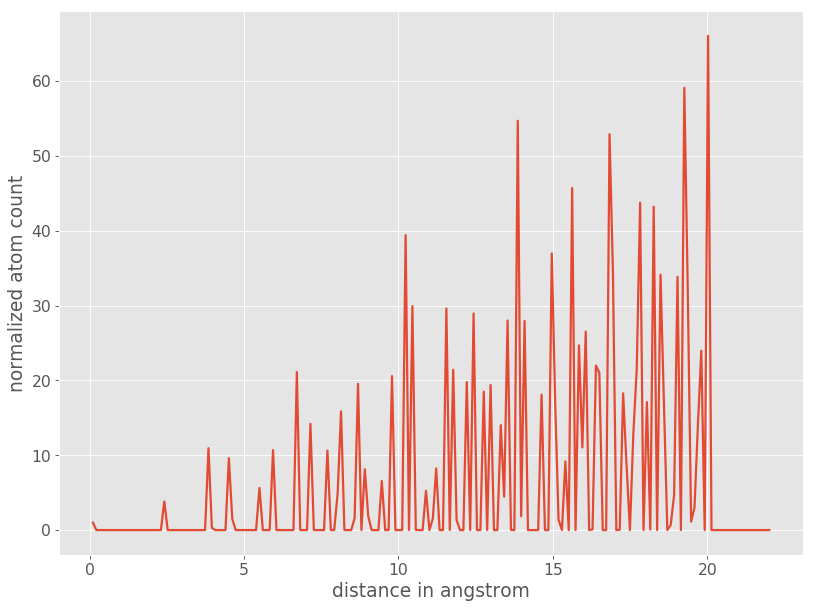

In [12]:
plt.plot(bin_centers, pdf)
plt.ylabel("normalized atom count")
plt.xlabel("distance in angstrom")
plt.show()

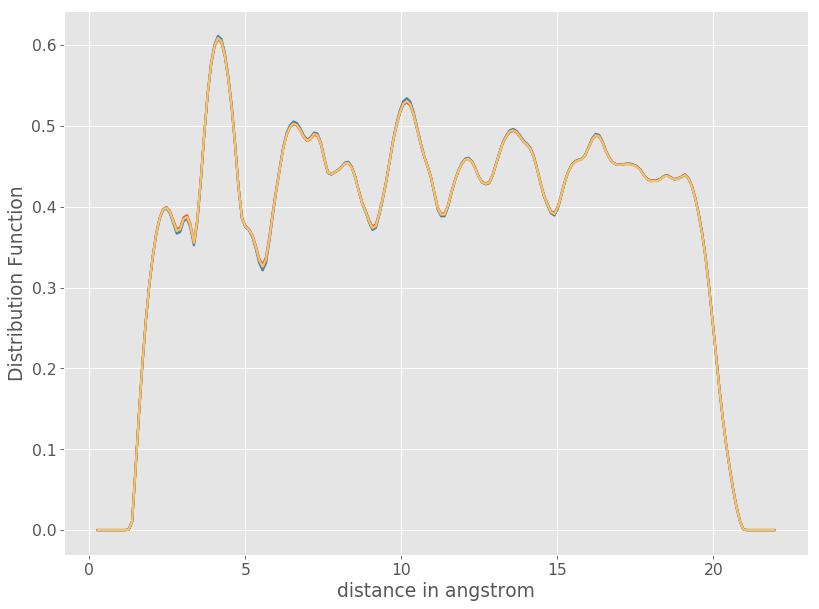

In [15]:
plt.plot(bin_centers1, lst_all[1,:])
plt.plot(bin_centers1, lst_all[2,:])
plt.plot(bin_centers1, lst_all[3,:])
plt.plot(bin_centers1, lst_all[4,:])
plt.plot(bin_centers1, lst_all[5,:])
plt.ylabel("Distribution Function")
plt.xlabel("distance in angstrom")
plt.show()

In [31]:
from sklearn.decomposition import PCA

In [32]:
pca = PCA(n_components=10)

In [33]:
scores = pca.fit_transform(lst_all)

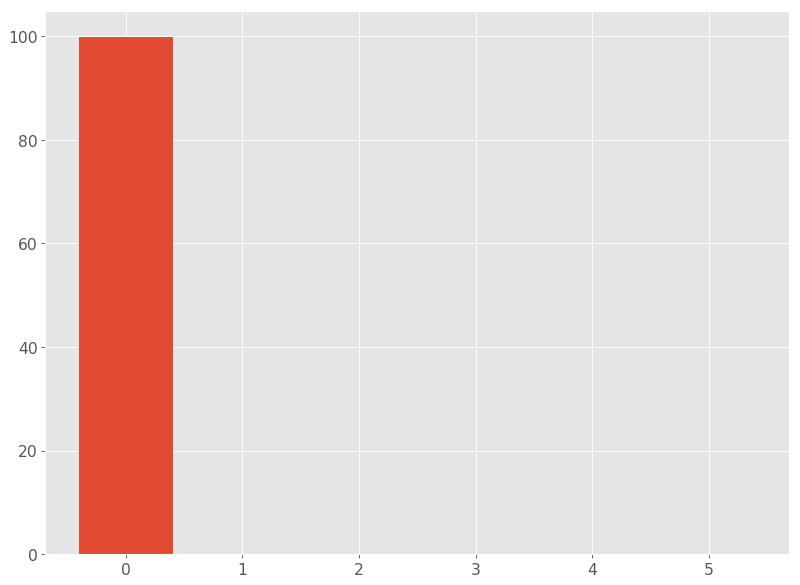

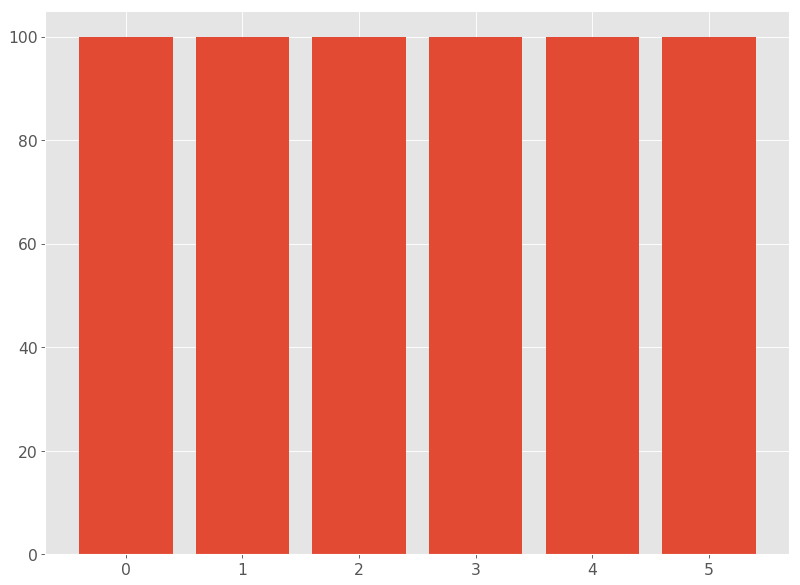

In [35]:
ex_var = pca.explained_variance_ratio_
cum_sum = np.cumsum(ex_var*100)

plt.bar(np.arange(ex_var.size), ex_var * 100)
plt.show()

plt.bar(np.arange(ex_var.size), cum_sum)
plt.show()

In [47]:
np.save("rdf_scores1.npy", scores)

In [45]:
c = np.arange(1, scores.shape[0]+1) * 100

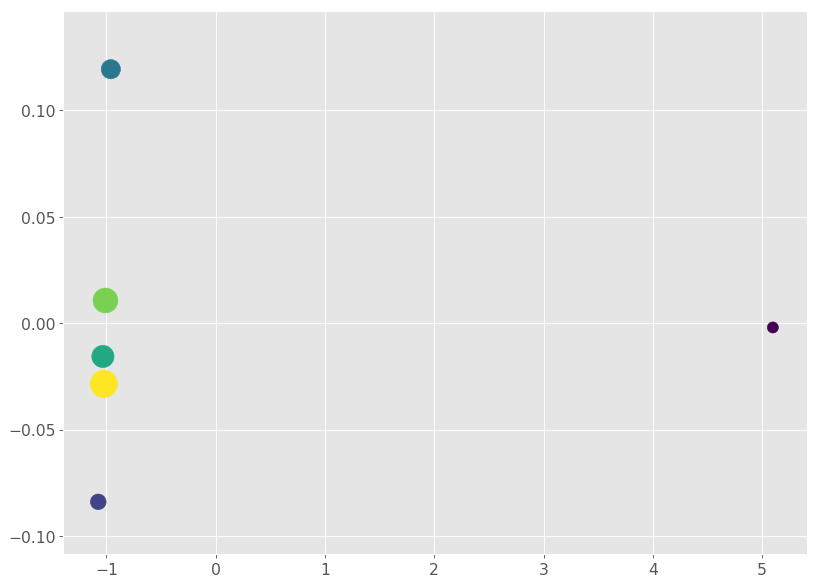

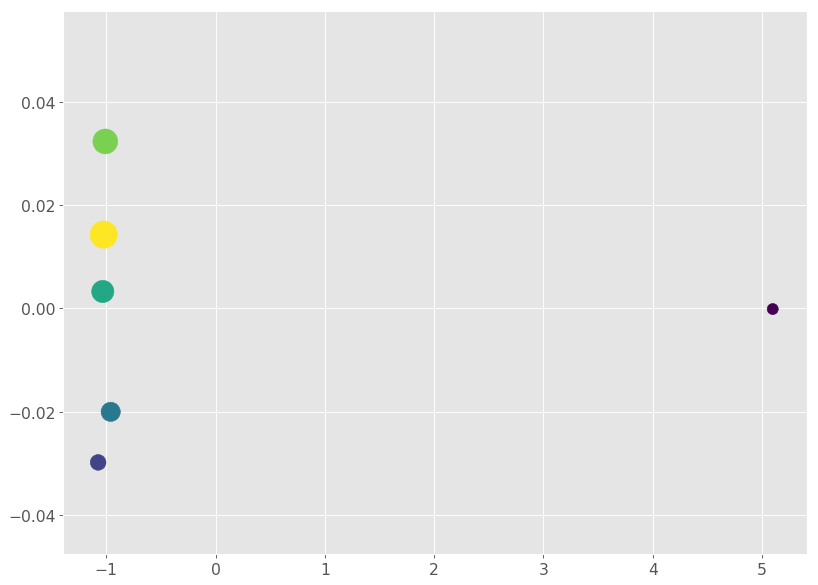

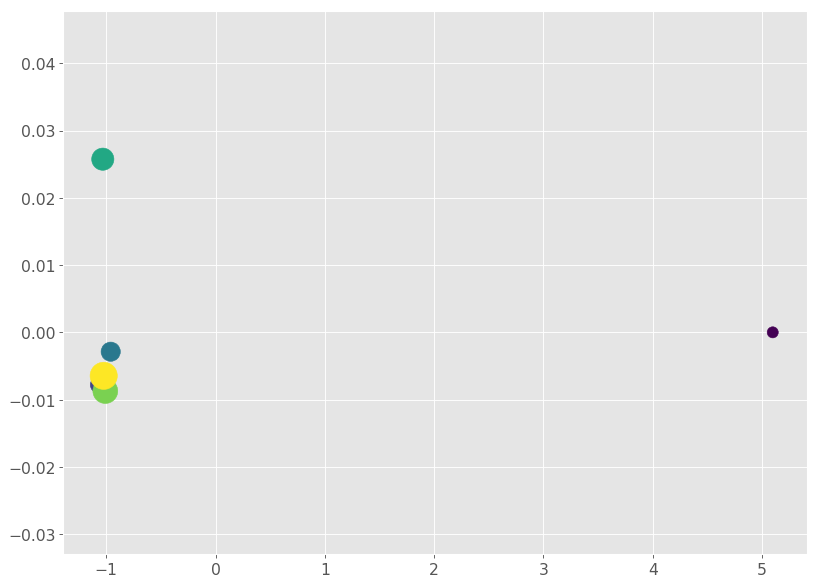

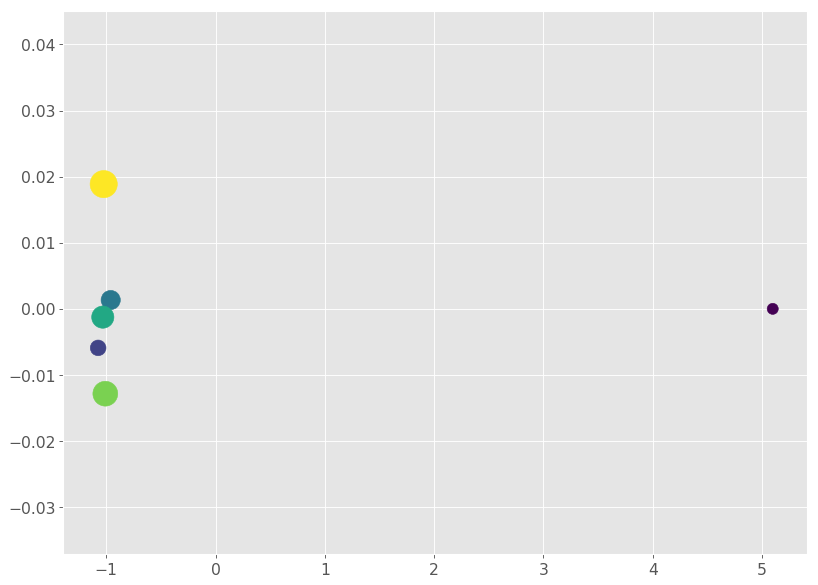

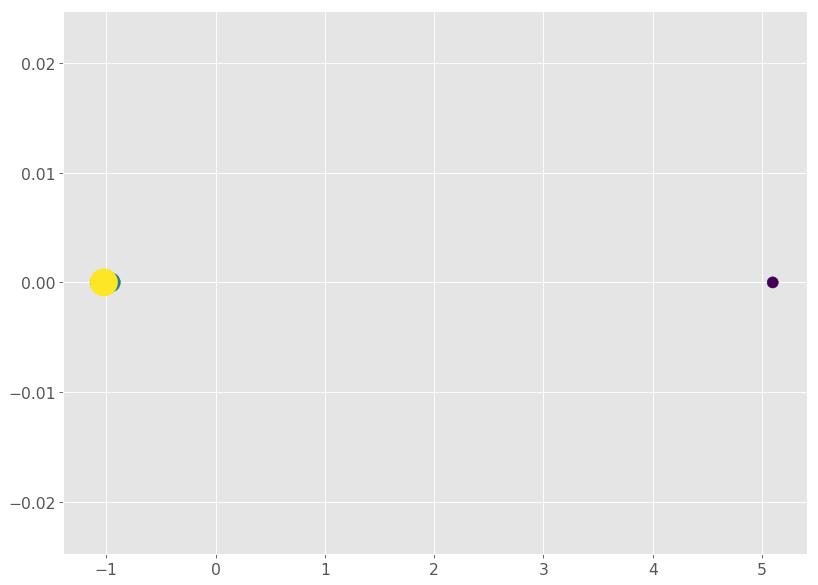

In [46]:
plt.scatter(scores[:,0], scores[:,1], c=c, s=c)
plt.show()
plt.scatter(scores[:,0], scores[:,2], c=c, s=c)
plt.show()
plt.scatter(scores[:,0], scores[:,3], c=c, s=c)
plt.show()
plt.scatter(scores[:,0], scores[:,4], c=c, s=c)
plt.show()
plt.scatter(scores[:,0], scores[:,5], c=c, s=c)
plt.show()